In [1]:
from config import*
from SPP_AD import*
from Wfamily import*
from Model import*
from NTK import*

/envs/common/lib/python3.12/site-packages/scipy/stats/_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


family_len:  3079


In [2]:
WPINN_model = WPINN(input_size = n_collocation, 
                    num_hidden_layers = 6, 
                    hidden_neurons = 100, 
                    family_size = len_family).to(device)

optimizer = optim.Adam(WPINN_model.parameters(), lr=1e-5)

In [3]:
x_interior = x_collocation.clone()

def wpinn_loss():   

    global c,b
    c, b = WPINN_model(x_interior)

    u  = torch.mv(Wfamily, c) + b
    u_x = torch.mv(DWx, c)
    u_xx = torch.mv(DW2x, c)

    u_pred_bc_left = torch.mv(Wbc_left, c) + b
    u_pred_bc_right = torch.mv(Wbc_right, c) + b
    
    pde_loss = torch.mean((e*u_xx + (1+e)*u_x + u) ** 2)    

    bc_loss = torch.mean((u_pred_bc_left - u_bc_left) ** 2) + \
              torch.mean((u_pred_bc_right - u_bc_right) ** 2)
    
    total_loss = pde_loss + bc_loss
    
    return total_loss, pde_loss, bc_loss


NTK_WPINN = []
itr = [0, 1000, 10000, 50000]

def train_wpinn(num_epochs, num_prints):

    for epoch in tqdm(range(num_epochs)):
        
        optimizer.zero_grad()
        total_loss, pde_loss, bc_loss = wpinn_loss()
        
        total_loss.backward()
        optimizer.step()

        if epoch in itr: NTK_WPINN.append(WPINN_NTK(WPINN_model))
    
        if epoch % ((num_epochs-1)/num_prints) == 0:  # Print every num_prints epochs
            
            with torch.no_grad():
                numerical = torch.mv(Wval, c.cpu()) + b.cpu()
                errL2 = (torch.sum(torch.abs(exact-numerical)**2))**0.5 / (torch.sum(torch.abs(exact)**2))**0.5
                errMax = torch.max(torch.abs(exact-numerical))

            print(f'Epoch [{epoch}/{num_epochs}], '
                f'Total Loss: {total_loss.item():.6f}, '
                f'PDE Loss: {pde_loss.item():.6f}, '
                f'BC Loss: {bc_loss.item():.6f}\n\t\t'
                f'RelativeL2: {errL2},\t\t'
                f'Max: {errMax}\n' )
            
        torch.cuda.empty_cache()

In [4]:
num_epochs = 5*10**4+1 
num_prints = 5
train_wpinn(num_epochs, num_prints)

  0%|          | 122/50001 [00:00<01:23, 597.14it/s]

Epoch [0/50001], Total Loss: 88082.703125, PDE Loss: 88081.890625, BC Loss: 0.815175
		RelativeL2: 0.7598331570625305,		Max: 2.480829954147339



 20%|██        | 10138/50001 [00:07<00:33, 1196.62it/s]

Epoch [10000/50001], Total Loss: 0.452084, PDE Loss: 0.129850, BC Loss: 0.322234
		RelativeL2: 0.7299623489379883,		Max: 2.0127971172332764



 40%|████      | 20236/50001 [00:15<00:23, 1283.23it/s]

Epoch [20000/50001], Total Loss: 0.244206, PDE Loss: 0.243559, BC Loss: 0.000647
		RelativeL2: 0.03291518986225128,		Max: 0.09100127220153809



 60%|██████    | 30230/50001 [00:22<00:14, 1324.97it/s]

Epoch [30000/50001], Total Loss: 0.131683, PDE Loss: 0.131683, BC Loss: 0.000000
		RelativeL2: 0.0005051216576248407,		Max: 0.0016064643859863281



 80%|████████  | 40212/50001 [00:30<00:07, 1286.78it/s]

Epoch [40000/50001], Total Loss: 0.020301, PDE Loss: 0.020300, BC Loss: 0.000001
		RelativeL2: 0.00128004583530128,		Max: 0.003666400909423828



100%|██████████| 50001/50001 [00:37<00:00, 1336.63it/s]

Epoch [50000/50001], Total Loss: 0.038308, PDE Loss: 0.038308, BC Loss: 0.000000
		RelativeL2: 0.0006257464992813766,		Max: 0.0017464160919189453



In [5]:
# Save NTK eigen values
file_name = "WPINN_ntk.csv" 
np.savetxt(file_name, NTK_WPINN, delimiter=",")

RelativeL2: 0.0006195977912284434,		 Max: 0.0017571449279785156



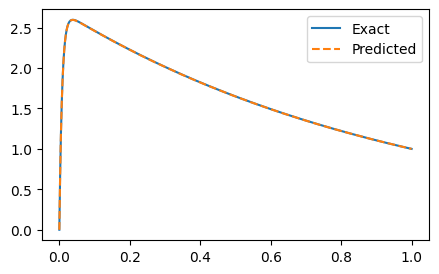

In [5]:
# Testing and Plotting
u_pred = (torch.mv(Wtest, c.cpu()) + b.cpu()).detach().numpy()
errL2 = (np.sum(np.abs(u_exact-u_pred)**2))**0.5 / (np.sum(np.abs(u_exact)**2))**0.5
errMax = np.max(np.abs(u_exact-u_pred))

print(f'RelativeL2: {errL2},\t\t', f'Max: {errMax}\n' )


fig = plt.figure(figsize=(5,3))
plt.plot(x_test, u_exact, label='Exact')
plt.plot(x_test, u_pred, '--', label='Predicted')
plt.legend()
plt.show()
